# Visualizing MCMC

- Diagnostico de hellman rubyn o algo así
- Triangle plot se puede hacer con pandas pero la maestra usa: Corner y getdist
- Histogramas con los puntos de todas las cadenas
- Incluir el prior
- Vamos a hablar el máximo del posterior

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from getdist import plots, MCSamples
import getdist

In [59]:
def likelihood(x, y, model, sigma, theta):
    suma = 0
    for i in range(len(x)):
        suma += (y[i] - model(x[i], theta))**2 / sigma[i]**2
    return -(1/2) * suma

In [60]:
# Define the model
def line(x, theta):
    return x*theta[0]+theta[1]

In [71]:
# Tasa de aceptación
def tasaFallos(lista, pasos):
    tasa = []
    for index, fail in enumerate(lista):
        tasa.append(fail/pasos)
    return tasa

In [75]:
def montecarlo(x, y, model, sigmaY, initPoints, pasosTotales, sigmaX):
    np.random.seed(500)
    markovMatrix = []
    markovChain = []
    rechazado = []
    for index, point in enumerate(initPoints):
        p_old = point
        L_old = likelihood(x, y, line, sigmaY, p_old)
        markovChain = [[p_old, L_old]]
        rechazado.append(0)
        
        for paso in range(pasosTotales):
            p_new = [p_old[0] + sigmaX[0] * np.random.randn(), p_old[1] + sigmaX[1] * np.random.randn()]
            L_new = likelihood(x, y, line, sigmaY, p_new)

            if (L_new > L_old):
                markovChain.append([p_new, L_new])
                p_old = p_new
                L_old = L_new
            elif (np.exp(L_new) / np.exp(L_old) > np.random.randn()):
                markovChain.append([p_new, L_new])
                p_old = p_new
                L_old = L_new
            else:
                markovChain.append([p_new, L_new])
                rechazado[index] += 1
        
        markovMatrix.append(markovChain)
    rechazados = tasaFallos(rechazado, pasosTotales)        
    return [markovMatrix, rechazados]
    

In [105]:
theta = [10, 12]
sigmaX = [0.1, 0.1]

x = np.linspace(0, 10, 1000)
y = x*theta[0]+theta[1]
sigmaY = [0.1 for point in y]
initPoints = [[5, 10],[7, 13], [15, 13], [15, 7], [7, 7]]

chain = montecarlo(x, y, line, sigmaY, initPoints, 3000, sigmaX)
ajuste = chain[0]
failed = chain[1]

<ipython-input-75-da11bc426067>:20: RuntimeWarning: invalid value encountered in double_scalars
  elif (np.exp(L_new) / np.exp(L_old) > np.random.randn()):


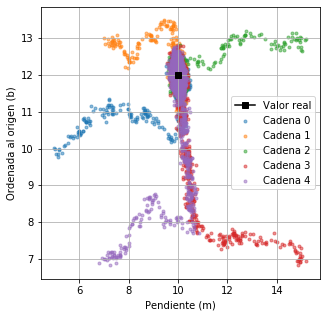

In [115]:
fig, ax0 = plt.subplots(figsize=(5, 5))
for index, cadenita in enumerate(ajuste):
    m = [punto[0] for punto, likelihood in cadenita]
    b = [punto[1] for punto, likelihood in cadenita]
    likelihoods = [likelihood for punto, likelihood in cadenita]
    chain_plot = ax0.scatter(m, b, marker = '.', alpha = 0.5, label = f"Cadena {index}")
    
plt.plot(theta[0], theta[1], marker = 's', label = 'Valor real', c = 'Black')
plt.legend()
ax0.set_xlabel('Pendiente (m)')
ax0.set_ylabel('Ordenada al origen (b)') 

ax0.grid()

In [107]:
for index, fail in enumerate(failed):
    print(f"La tasa de rechazo de la cadena {index} es: {fail}")

La tasa de rechazo de la cadena 0 es: 0.7626666666666667
La tasa de rechazo de la cadena 1 es: 0.748
La tasa de rechazo de la cadena 2 es: 0.754
La tasa de rechazo de la cadena 3 es: 0.7636666666666667
La tasa de rechazo de la cadena 4 es: 0.7536666666666667


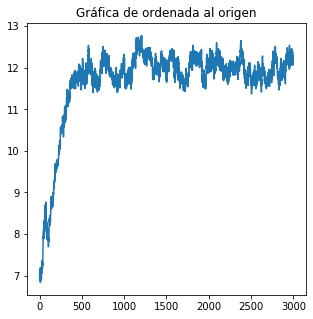

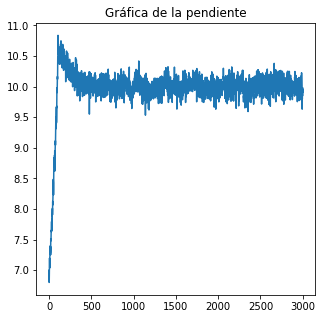

In [116]:
# Veamos la distribución conforme a los pasos de alguna cadena cualquiera y los parámetros
# Tomaremos las y y x que nos quedaron en la graficación pasada
fig, ax0 = plt.subplots(figsize=(5, 5))
pasos = range(3001)
ax0.plot(pasos, b)
ax0.set_title("Gráfica de ordenada al origen")
plt.show()

fig, ax1 = plt.subplots(figsize=(5, 5))
ax1.plot(pasos, m)
ax1.set_title("Gráfica de la pendiente")
plt.show()

Note que las gráficas están muy alejadas de loq ue deseamos reportar, podemos aplicar un "burning" o algo para que se vea más cerca lo que queremos, en el caso de la ordenada al origen aplicaremos un burning en el paso 1000 al igual que a la pendiente

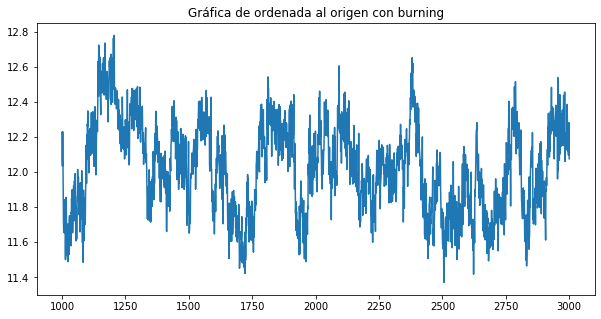

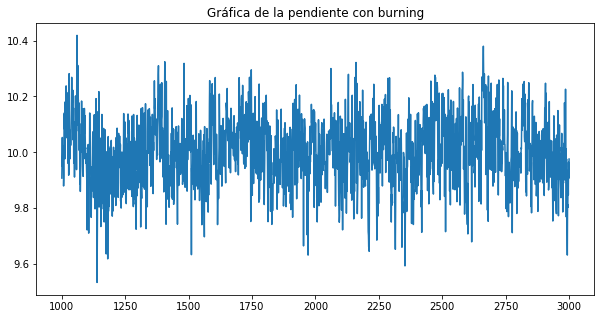

In [117]:
fig, ax0 = plt.subplots(figsize=(10, 5))
pasos = list(range(3001))
ax0.plot(pasos[1000:], b[1000:])
ax0.set_title("Gráfica de ordenada al origen con burning")
plt.show()

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(pasos[1000:], m[1000:])
ax1.set_title("Gráfica de la pendiente con burning")
plt.show()

# Gráficas triangulares con getdist

Removed no burn in


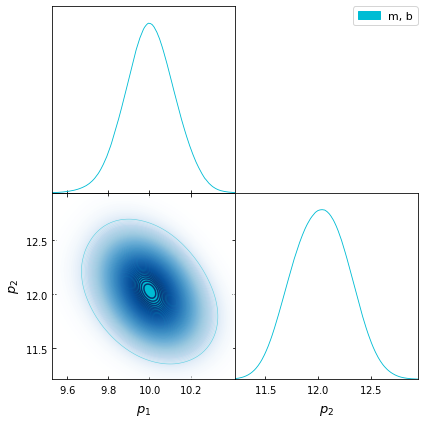

In [136]:
g = plots.get_subplot_plotter(subplot_size=3)

for index, cadenita in enumerate(ajuste):
    data = [punto for punto, likelihood in cadenita]

labels =[]
samples = MCSamples(samples=np.array(data[1000:]))
g.triangle_plot(samples, filled=True, legend_labels=["m, b"], shaded=True, contour_colors=["#00bcd4"])

# Histogramas en 2D

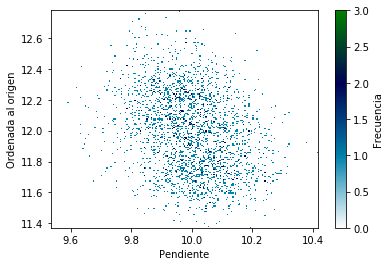

In [160]:
m = [point[0] for point in data[500:]]
b = [point[1] for point in data[500:]]

plt.hist2d(m, b, bins = 200, cmap = 'ocean_r')
plt.ylabel("Ordenada al origen")
plt.xlabel('Pendiente')
plt.colorbar(label = 'Frecuencia')
plt.show()